11 de abril 2024.

Nancy Woolrich Sorroza

# Aplicando Python para análisis de precios: simulación de escenarios futuros de precios

<img style="float: right; margin: 0px 0px 15px 15px;" src="https://upload.wikimedia.org/wikipedia/commons/d/d7/Philippine-stock-market-board.jpg" width="400px" height="125px" />

> En la clase anterior vimos como importar datos de activos de la base de datos de Yahoo Finance usando el paquete pandas-datareader. En esta clase, veremos como pronosticar escenarios de evolución de precios, suponiendo que los rendimientos diarios se distribuyen normalmente. Como esta evolución de precios es aleatoria, utilizaremos la simulación montecarlo (hacer muchas simulaciones de escenarios de evolución de precios) para obtener probabilidades de que los precios de cierre estén encima de un valor umbral y tomar decisiones con base en estas probabilidades.

**Referencias:**
- http://pandas.pydata.org/
- http://www.learndatasci.com/python-finance-part-yahoo-finance-api-pandas-matplotlib/

## 1. Recordemos como descargar datos...

Antes que nada, para poder hacer simular escenarios de predicción de precios, vamos a recordar lo que hicimos en la clase pasada de descargar los datos de Yahoo Finance, utilizando el paquete `data` de la librería `pandas_datareader`.

Esta vez, utilizaremos los datos de precios de cierre ajustados de activos de la compañía Apple en el año 2016 para nuestra aplicación.

In [1]:
# Instalación del paquete

# conda install pandas-datareader
# pip install pandas-datareader

In [6]:
!pip install yfinance

  Obtaining dependency information for yfinance from https://files.pythonhosted.org/packages/14/03/3c854ca3e02eedf614abba4b2e177c469bf3af58207fa30d5098c5d652fe/yfinance-0.2.37-py2.py3-none-any.whl.metadata
  Obtaining dependency information for multitasking>=0.0.7 from https://files.pythonhosted.org/packages/3e/8a/bb3160e76e844db9e69a413f055818969c8acade64e1a9ac5ce9dfdcf6c1/multitasking-0.0.11-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.2/315.2 kB 2.1 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 3.7 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Obtaining dependency information for html5lib>=1.1 from https://files.pythonhosted.org/packages/6c/dd/a834df6482147d48e225a4951

In [8]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
def getClose(names, start, end):
    return yf.download(names, start=start, end=end)[["Adj Close"]]

In [22]:
aapl=getClose("AAPL", "2016-01-01", "2016-12-31")

[*********************100%%**********************]  1 of 1 completed


<Axes: ylabel='Frequency'>

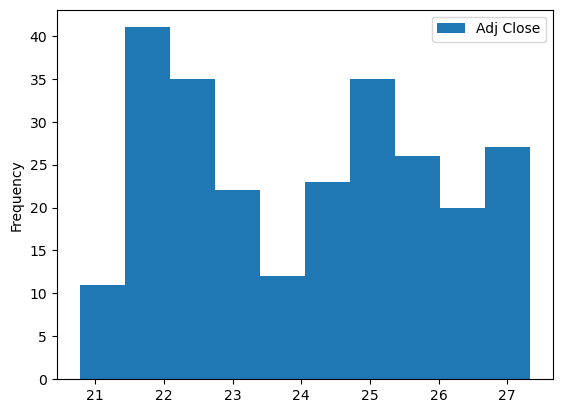

In [23]:
aapl.plot.hist()

## 2. Simulación de rendimientos diarios

Recordemos que los precios diarios de cierre ajustados no son un proceso estocástico estacionario, pero los rendimientos diarios si lo son. Por tanto calculamos los rendimientos a partir de los precios de cierre, obtenemos sus propiedades estadísticas muestrales y proyectamos los rendimientos. Luego, obtenemos la proyección de los precios.

Para una sucesión de precios $\{S_t\}_{t=0}^{n}$, el rendimiento simple $R_t$ se define como el cambio porcentual

$$
R_t=\frac{S_t-S_{t-1}}{S_{t-1}}\approx \ln\left(\frac{S_t}{S_{t-1}}\right)=r_t.
$$
para $t=1,\ldots,n$.

Para el ejemplo en curso, ¿cómo calcular esto?

Además, supusimos que los rendimientos diarios eran una variable aleatoria con distribución normal (que se caracteriza con su media y varianza). Por tanto obtenemos la media y desviación estandar muestrales. Hagamos una función que retorne lo anterior.

In [24]:
R = aapl.pct_change() #cambio porcentual se saca ((N-A)/A)

<Axes: ylabel='Frequency'>

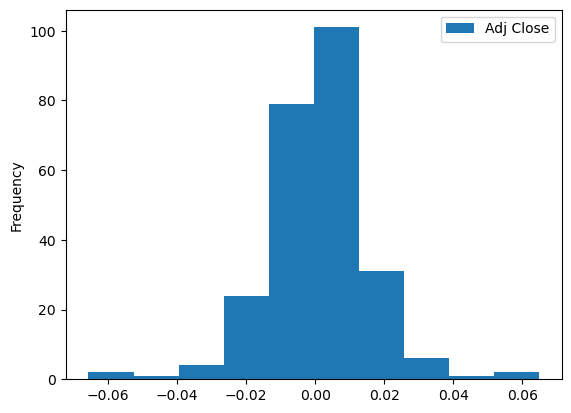

In [25]:
R.plot.hist()

Prueba de hipótesis: comparar los datos de para ver si cambia o no.

Distribución normal: Con la media y la desviación estandar

Entonces, suponemos que el cambio porcentual de los precios (rendimientos diarios) tiene una distribución normal.

¿Cómo se caracteriza una [distribución normal](https://es.wikipedia.org/wiki/Distribuci%C3%B3n_normal)?

In [26]:
R.describe

<bound method NDFrame.describe of             Adj Close
Date                 
2016-01-04        NaN
2016-01-05  -0.025059
2016-01-06  -0.019570
2016-01-07  -0.042205
2016-01-08   0.005288
...               ...
2016-12-23   0.001978
2016-12-27   0.006351
2016-12-28  -0.004264
2016-12-29  -0.000257
2016-12-30  -0.007796

[252 rows x 1 columns]>

In [27]:
R.mean()

Adj Close    0.000574
dtype: float64

In [28]:
R.std()

Adj Close    0.014731
dtype: float64

(array([ 14.,  55., 100.,  65.,  18.]),
 array([-0.03635844, -0.02183423, -0.00731003,  0.00721417,  0.02173838,
         0.03626258]),
 <BarContainer object of 5 artists>)

<Figure size 640x480 with 0 Axes>

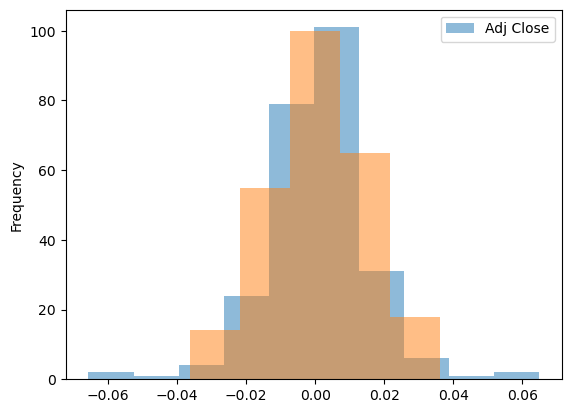

In [37]:
import numpy as np
sim_R=np.random.normal(R.mean(), R.std(), 252) #Dist normal aleatoria y extrae 252 muestras

plt.figure()
R.plot.hist(alpha=0.5)
plt.hist(sim_R, alpha=0.5, bins=5)

Habiendo caracterizado los rendimientos diarios como una variable aleatoria normal con la media y la varianza muestral obtenida de los datos desde 2016, podemos generar números aleatorios con estas características para simular el comportamiento de los precios de cierre de las acciones en el 2021 (hay un supuesto de que las cosas no cambiarán fundamentalmente).

Sin embargo, cada simulación que hagamos nos conducirá a distintos resultados (los precios siguen evolucionando aleatoriamente). Entonces, lo que haremos es simular varios escenarios para así ver alguna tendencia y tomar decisiones.

Hagamos una función que simule varios escenarios de rendimientos diarios y que devuelva un dataframe con esta simulación.

In [51]:
def simR(media, std, start, dias, N): #media, estandar, cantidad de días, cantidad de simulaciones
    sim_R = np.random.normal(media, std, size=(dias, N)) +1
    fechas = pd.date_range(start, periods=dias)
    return pd.DataFrame(sim_R, index=fechas)

In [74]:
aapl.iloc[-1]

Adj Close    26.912582
Name: 2016-12-30 00:00:00, dtype: float64

In [66]:
np.random.seed(5)
sim_R= simR(R.mean(), R.std(), "2017-01-01", 10, 100) #Simulación de 10 días 100 veces

In [67]:
sim_R.head(3)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
2017-01-01,1.007073,0.995699,1.036382,0.996860,1.002188,1.023885,0.987180,0.991858,1.003337,0.995714,...,1.017389,0.993182,0.999408,0.990367,0.991832,1.012185,0.994012,0.993471,1.007844,1.007946
2017-01-02,1.012247,1.003089,0.974739,1.009859,1.007914,1.015572,0.988104,1.037708,0.982419,1.011282,...,1.004254,1.017473,1.012888,1.004807,0.985907,1.013933,1.000930,0.997038,1.013980,1.009675
2017-01-03,1.007933,0.983610,0.991580,0.975473,1.003438,1.000990,1.014311,1.003697,0.995153,1.031678,...,0.987674,0.992647,0.981744,0.985949,1.017418,0.993074,1.013758,0.997978,1.005672,0.993115


In [68]:
precios_simulados = sim_R.cumprod()*26.912582 #producto acumulado
precios_simulados.tail()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
2017-01-06,27.936398,27.943493,27.816664,26.463434,27.397177,27.592433,27.042503,27.156185,25.767262,28.196249,...,27.184195,25.383131,26.043266,25.528342,26.759981,26.761372,27.583122,26.344613,27.905105,28.648385
2017-01-07,27.758733,27.919220,28.604695,25.799271,26.577903,27.192766,26.900369,26.712715,25.765678,28.175330,...,27.262341,25.795292,25.810575,25.716082,25.934851,26.354081,27.816467,26.731438,28.308862,29.116134
2017-01-08,27.104540,27.721105,27.533998,25.754825,26.685109,27.072344,26.548482,26.897042,25.982251,28.246939,...,27.082582,26.254015,25.894522,26.860268,25.825640,26.267913,28.777696,26.546631,29.262484,27.819592
2017-01-09,26.876720,28.331167,28.218328,25.964385,26.467311,27.055123,26.891231,27.061253,26.384655,27.988265,...,26.570419,26.462982,26.287490,27.033291,25.345457,26.078984,28.680418,26.744696,29.406002,27.675545
2017-01-10,26.240439,27.598832,27.827413,25.592734,26.244233,26.648257,26.852652,26.838571,26.480043,28.005718,...,26.426881,26.249695,25.888802,26.928100,25.646860,26.401045,29.023464,26.738424,29.560146,27.736940


In [71]:
precios_simulados.mean(axis=1)#toma el promedio del eje x (axis=1)

2017-01-01    26.964311
2017-01-02    26.991354
2017-01-03    26.960020
2017-01-04    27.031980
2017-01-05    27.031001
2017-01-06    27.039187
2017-01-07    27.045059
2017-01-08    27.052862
2017-01-09    27.158428
2017-01-10    27.203875
Freq: D, dtype: float64

## 3. Proyección de precios de cierre

Por tanto, para calcular los precios, tenemos:

$$\begin{align}
p_i&=p_{i-1}(R_i+1)\\
p_{i+1}&=p_i(R_{i+1}+1)=p_{i-1}(R_i+1)(R_{i+1}+1)\\
&\vdots\\
p_{i+k}&=p_{i-1}(R_i+1)\cdots(R_{i+k}+1).
\end{align}$$

Si hacemos $i=0$ en la última ecuación, tenemos que $p_{k}=p_{-1}(R_0+1)\cdots(R_{k}+1)$, donde $p_{-1}$ es el último precio reportado en el 2018.

Con los rendimientos, calculamos los precios de cierre...

In [82]:
sim_R= simR(R.mean(), R.std(), "2017-01-01", 1000, 100000)
precios_cierre=sim_R.cumprod()*26.912582 

In [83]:
precios_cierre.mean(axis=1)

2017-01-01    26.926608
2017-01-02    26.941713
2017-01-03    26.955081
2017-01-04    26.968773
2017-01-05    26.982692
                ...    
2019-09-23    47.739262
2019-09-24    47.765955
2019-09-25    47.792924
2019-09-26    47.822346
2019-09-27    47.849770
Freq: D, Length: 1000, dtype: float64

## 4. Probabilidad Precio-Umbral

Ya que tenemos muchos escenarios de precios proyectados, podemos ver varias cosas. Por ejemplo, ¿cuál es la probabilidad de que el precio de cierre sobrepase algún valor umbral en algún momento?

In [85]:
sim_R= simR(R.mean(), R.std(), "2017-01-01", 365, 10000)
(sim_R.cumprod()*26.912582 > 28).mean(axis=1) #Cuantas simulaciones fueron mayores a 28

2017-01-01    0.0032
2017-01-02    0.0295
2017-01-03    0.0643
2017-01-04    0.0990
2017-01-05    0.1295
               ...  
2017-12-27    0.6726
2017-12-28    0.6728
2017-12-29    0.6744
2017-12-30    0.6731
2017-12-31    0.6750
Freq: D, Length: 365, dtype: float64

In [87]:
msft = getClose("MSFT", "2016-01-01", "2016-12-31")
R_msft = msft.pct_change()
msft_mean = R_msft.mean()
msft_std = R_msft.std()
sim_R_msft = simR(msft_mean, msft_std, "2017-01-01", 365, 10000)
(sim_R_msft.cumprod()*56.632259 > 56.632259*1.05).mean(axis=1)

[*********************100%%**********************]  1 of 1 completed


2017-01-01    0.0004
2017-01-02    0.0086
2017-01-03    0.0275
2017-01-04    0.0485
2017-01-05    0.0737
               ...  
2017-12-27    0.7347
2017-12-28    0.7342
2017-12-29    0.7337
2017-12-30    0.7336
2017-12-31    0.7329
Freq: D, Length: 365, dtype: float64

___
Entonces, ya aprendimos a bajar datos con pandas-datareader. En específico, a partir de los precios de cierre ajustados obtuvimos los rendimientos diarios.

Suponiendo que los rendimientos diarios son un proceso estocástico estacionario de distribución normal, pudimos caracaterizarlo y proyectar varios escenarios de evolución de los precios (montecarlo).

Con estas proyecciones pudimos calcular probabilidades de sobrepasar cierto precio umbral: toma de decisiones.

# A06

-**Problema 1**

<img style="float: center" src="1.png" width="3500px" height="1025px"/>

In [2]:
import numpy as np
import pandas as pd

In [27]:
N=100000
pulseras=np.random.uniform(2,3)+pd.DataFrame(np.random.normal(2.5, 1, (20,N))).sum()
p=pulseras.mean()

In [28]:
N=100000
aretes=np.random.uniform(4,7)+pd.DataFrame(np.random.normal(2, 1, (10,N))).sum()
ar=aretes.mean()

In [29]:
N=100000
anillo=np.random.uniform(4,7)+pd.DataFrame(np.random.normal(1, 1.5, (15,N))).sum()
a=anillo.mean()

In [30]:
N=100000
collar=np.random.uniform(14,17)+pd.DataFrame(np.random.normal(2, 0.5, (8,N))).sum()+pd.DataFrame(np.random.normal(6, 2, (8,N))).sum()
c=collar.mean()

In [33]:
Tiempo_total=p+ar+a+c
Tiempo_total

177.24964747049103

Se tardará 177.24 días en tener 20 pulseras, 10 pares de aretes, 15 anillos y 8 collares en su inventario

-**Problema 2**

<img style="float: center" src="2.png" width="3500px" height="1025px"/>

In [36]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [41]:
def getClose(names, start, end):
    return yf.download(names, start=start, end=end)[["Adj Close"]]

def simR(media, std, start, dias, N): #media, estandar, cantidad de días, cantidad de simulaciones
    sim_R = np.random.normal(media, std, size=(dias, N)) +1
    fechas = pd.date_range(start, periods=dias)
    return pd.DataFrame(sim_R, index=fechas)


In [45]:
aapl.iloc[-1]

Adj Close    192.284637
Name: 2023-12-29 00:00:00, dtype: float64

In [46]:
amzn.iloc[-1]

Adj Close    151.940002
Name: 2023-12-29 00:00:00, dtype: float64

In [47]:
msft.iloc[-1]

Adj Close    375.345886
Name: 2023-12-29 00:00:00, dtype: float64

In [48]:
# Apple
aapl=getClose("AAPL", "2023-01-01", "2023-12-31")
R_aapl = aapl.pct_change()
aapl_mean = R_aapl.mean()
aapl_std = R_aapl.std()
sim_R_aapl= simR(aapl_mean, aapl_std, "2024-01-01", 365, 10000)
(sim_R_aapl.cumprod()*192.284637 > 192.284637*1.06).mean(axis=1) 

[*********************100%%**********************]  1 of 1 completed


2024-01-01    0.0000
2024-01-02    0.0008
2024-01-03    0.0063
2024-01-04    0.0187
2024-01-05    0.0338
               ...  
2024-12-26    0.9926
2024-12-27    0.9927
2024-12-28    0.9924
2024-12-29    0.9923
2024-12-30    0.9930
Freq: D, Length: 365, dtype: float64

In [50]:
# Microsoft
msft = getClose("MSFT", "2023-01-01", "2023-12-31")
R_msft = msft.pct_change()
msft_mean = R_msft.mean()
msft_std = R_msft.std()
sim_R_msft = simR(msft_mean, msft_std, "2024-01-01", 365, 10000)
(sim_R_msft.cumprod()*375.345886 > 375.345886*1.06).mean(axis=1)

[*********************100%%**********************]  1 of 1 completed


2024-01-01    0.0003
2024-01-02    0.0069
2024-01-03    0.0253
2024-01-04    0.0485
2024-01-05    0.0787
               ...  
2024-12-26    0.9757
2024-12-27    0.9755
2024-12-28    0.9764
2024-12-29    0.9756
2024-12-30    0.9761
Freq: D, Length: 365, dtype: float64

In [51]:
# Amazon
amzn = getClose("AMZN", "2023-01-01", "2023-12-31")
R_amzn = amzn.pct_change()
amzn_mean = R_amzn.mean()
amzn_std = R_amzn.std()
sim_R_amzn = simR(amzn_mean, amzn_std, "2024-01-01", 365, 10000)
(sim_R_amzn.cumprod()*151.940002 > 151.940002*1.06).mean(axis=1)

[*********************100%%**********************]  1 of 1 completed


2024-01-01    0.0021
2024-01-02    0.0351
2024-01-03    0.0785
2024-01-04    0.1235
2024-01-05    0.1631
               ...  
2024-12-26    0.9758
2024-12-27    0.9766
2024-12-28    0.9764
2024-12-29    0.9774
2024-12-30    0.9784
Freq: D, Length: 365, dtype: float64

In [70]:
#Apple
sim_R_aapl= simR(R_aapl.mean(), R_aapl.std(), "2023-01-01", 365, 100000)
precios_cierre_aapl=sim_R_aapl.cumprod()*192.284637  #PRECIOS DE CIERRE
precios_cierre_aapl.mean(axis=1)

2023-01-01    192.640163
2023-01-02    193.002920
2023-01-03    193.359677
2023-01-04    193.705538
2023-01-05    194.056982
                 ...    
2023-12-27    372.386466
2023-12-28    373.069925
2023-12-29    373.738562
2023-12-30    374.427837
2023-12-31    375.108048
Freq: D, Length: 365, dtype: float64

In [98]:
#Rendimiento (no en %) de Apple
Rendimiento_aapl=((379.230595-152.314231)/152.314231)
Rendimiento_aapl

1.48979095722185

In [99]:
ROI_aapl=((Rendimiento_aapl*10000-10000)/10000)*100
ROI_aapl

48.979095722184994

In [72]:
#Microsoft
sim_R_msft= simR(R_msft.mean(), R_msft.std(), "2023-01-01", 365, 100000)
precios_cierre_msft=sim_R_msft.cumprod()*375.345886  #PRECIOS DE CIERRE
precios_cierre_msft.mean(axis=1)

2023-01-01    376.105012
2023-01-02    376.864335
2023-01-03    377.644829
2023-01-04    378.408101
2023-01-05    379.163126
                 ...    
2023-12-27    764.641552
2023-12-28    766.168001
2023-12-29    767.697170
2023-12-30    769.222704
2023-12-31    770.703673
Freq: D, Length: 365, dtype: float64

In [108]:
#Rendimiento (no en %) de Microsoft
Rendimiento_msft=((770.703673-376.105012)/376.105012)
Rendimiento_msft

1.0491715037288576

In [109]:
ROI_msft=((Rendimiento_msft*10000-10000)/10000)*100
ROI_msft

4.917150372885754

In [106]:
#Amazon
sim_R_amzn= simR(R_amzn.mean(), R_amzn.std(), "2023-01-01", 365, 100000)
precios_cierre_amzn=sim_R_amzn.cumprod()*151.940002  #PRECIOS DE CIERRE
precios_cierre_amzn.mean(axis=1)

2023-01-01    152.320015
2023-01-02    152.704967
2023-01-03    153.078965
2023-01-04    153.447660
2023-01-05    153.825366
                 ...    
2023-12-27    376.162637
2023-12-28    377.080429
2023-12-29    378.037199
2023-12-30    378.986276
2023-12-31    379.946913
Freq: D, Length: 365, dtype: float64

In [107]:
#Rendimiento(no en %) de Amazon
Rendimiento_amzn=((379.946913-152.320015)/152.320015)
Rendimiento_amzn

1.4943991306723543

In [110]:
ROI_amzn=((Rendimiento_amzn*10000-10000)/10000)*100
ROI_amzn

49.43991306723543

1. La probabilidad de que crezca en un 6% el dinero en Apple es de 99.30%, en Microsoft es de 97.61% y en Amazon es de 97.84%.

2. El retorno promedio en Apple es de 48.98%%, en Microsoft es de 4.92% y en Amazon es de 49.44%.

3. Yo recomendaría invertir en Apple, tomando en cuenta lo anterior.
